## Value Iteration

In the next section of the notebook, we will be looking at convergence rates of Value Iteration methods. In particular, we will be demonstrating Gauss-Seidel, Jacobi, Gauss-Seidel-Jacobi, and Prioritized Sweeping variations on plain Value Iteration.

Various resources that can help with the understanding of these methods can be found here:

Prioritized sweeping:

http://webdocs.cs.ualberta.ca/~sutton/book/ebook/node98.html
http://ipvs.informatik.uni-stuttgart.de/mlr/wp-content/uploads/2016/04/02-MarkovDecisionProcess.pdf
http://www.jmlr.org/papers/volume6/wingate05a/wingate05a.pdf

Jacobi:

https://tspace.library.utoronto.ca/bitstream/1807/24381/6/Shlakhter_Oleksandr_201003_PhD_thesis.pdf

Gauss-Seidel

http://ipvs.informatik.uni-stuttgart.de/mlr/wp-content/uploads/2016/04/02-MarkovDecisionProcess.pdf

In addition sections 6.3 of Puterman (1994) and the Sutton Reinforcement Learning text have detailed descriptions of theoretical methods.

To better understand Value Iteration, let's generate the optimal Value functions and policies and compare how fast each method converges!


In [9]:
from mdp_matrix import GridWorld
from value_iteration_matrix import ValueIteration, GaussSeidelValueIteration, JacobiValueIteration, PrioritizedSweepingValueIteration, GaussSeidelJacobiValueIteration
import matplotlib.pyplot as plt
import numpy as np
import pprint
from IPython.display import Image
from IPython.core.display import HTML 

## Grid world
We set up a grid world MDP similar to the one shown on Sutton page 82

In [6]:
Image(url= "https://webdocs.cs.ualberta.ca/~sutton/book/ebook/figtmp15.png")

In [10]:
test_rewards = [[i, j, -1] for i in range(5) for j in range(5)]
test_rewards[2] = [0, 2, 1]
test_rewards[23] = [4,3,1]

# Instantiate the gridworld
gw = GridWorld(5, test_rewards)
pprint.pprint(np.reshape(gw.R, (5,5)))

array([[-1., -1.,  1., -1., -1.],
       [-1., -1., -1., -1., -1.],
       [-1., -1., -1., -1., -1.],
       [-1., -1., -1., -1., -1.],
       [-1., -1., -1.,  1., -1.]])


Converged in 1675 iterations (67 sweeps)
Converged in 1125 iterations (45 sweeps)
Converged in 1125 iterations (45 sweeps)
Converged in 150 iterations (6 sweeps)
Converged in 150 iterations (6 sweeps)
Converged in 1189 iterations


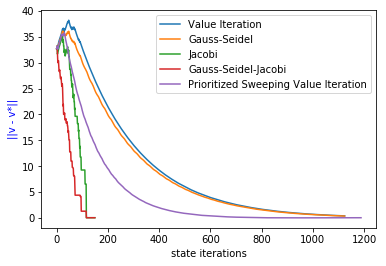

In [4]:
%matplotlib inline

vl = ValueIteration(gw)

optimal_policy, optimal_value, _  = vl.run()
optimal_policy, v, vs = vl.run(optimal_value=optimal_value, theta=0.01)
plt.plot(vs)

vl = GaussSeidelValueIteration(gw)

optimal_policy, v, vsgs = vl.run(optimal_value=optimal_value, theta=0.01)
plt.plot(vsgs)

vl = JacobiValueIteration(gw)
optimal_policy, v, vsj = vl.run(optimal_value=optimal_value, theta=0.01)
plt.plot(vsj)

vl = GaussSeidelJacobiValueIteration(gw)
optimal_policy, v, vsj = vl.run(optimal_value=optimal_value, theta=0.01)
plt.plot(vsj)

vl = PrioritizedSweepingValueIteration(gw)
optimal_policy, v, vsps = vl.run(optimal_value=optimal_value)
plt.plot(vsps)

plt.xlabel('state iterations')
plt.ylabel('||v - v*||',color='b')

plt.legend(['Value Iteration', 'Gauss-Seidel', 'Jacobi', 'Gauss-Seidel-Jacobi', 'Prioritized Sweeping Value Iteration'], loc='upper right')

plt.show()


## What just ran?

As you can see from the above, we found the optimal policies and value functions for a simple GridWorld problem.

As you can see, Gauss-Seidel-Jacobi and Jacobi splitting methods appear to perform the best in practice, quickly dropping to the optimal Value function.

## What about the theory?

